In [1]:
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import numpy as np

# **Тестовое задание для стажеров в команду Data Science IDP**

## Задание 1
Опишите задачу с точки зрения NLP. Что это за задача, какие классические методы существуют для ее решения? Как ее можно решать через LLM? Как обычно оценивают качество моделей в этой задаче?

Рассматривается задача NER из NLP: поиск сущностей в заданном тексте. В данной работе встречаются следующие сущности: 
- **PER** (Person) — имена людей;
- **ORG** (Organization) — названия организаций;
- **LOC** (Location) — географические объекты;
- **EVT** (Event) — названия событий;
- **PRO** (Product) — названия продуктов;

С помощью LLM ее можно решать в виде корректировки промта и собственно загрузки промта в LLM, либо же с помощью файнтюнинга на данных. 

Классически используемые метрики в такой задаче это presicion, recall, F1, поскольку они в целом отражают то, как модель решила задачу

## Задание 2
Реализуйте чтение датасета в pandas DataFrame с обязательными колонками "document_id", "document_text", "entity", "gold_answer". Выведите шапку датафрейма.

Для этого подгрузим все файлы с заданного сайта в директорий, получим их имена, прогоним цикл по ним, чтобы выделить основную нужную информацию из файла: отрезаем часть строк в начале, которые не несут для нас необходимой информации, в файлах out аккуратно работаем с gold_answer, берем форму уже нормализованную, а не как она встречается в тексте

In [8]:
txt_files = sorted(glob.glob("brexit_ru.txt_file_*.txt"))
doc_ids = [os.path.splitext(os.path.basename(f))[0] for f in txt_files]

records = []
for doc_id in doc_ids:
    with open(f"{doc_id}.txt", encoding='utf-8') as f:
        lines = f.read().splitlines()
    document_text = "".join(lines[4:]).strip() # Пропуск ненужных строк

    out_file = f"{doc_id}.out" # Файл с gold_answer
    with open(out_file, encoding='utf-8') as f:
        lines = f.read().splitlines()[1:]  # Пропускаем заголовок

    for line in lines:
        parts = line.split('\t')
        if len(parts) < 3:
            continue
        surface, normal, entity_type = parts[:3]
        records.append({
            'document_id': doc_id,
            'document_text': document_text,
            'entity': entity_type,
            'gold_answer': normal.strip()
        })

df = pd.DataFrame(records)
df.head()

,document_id,document_text,entity,gold_answer
0,brexit_ru.txt_file_10,Тереза Мэй рассчитывает усидеть в седле до зав...,EVT,Brexit
1,brexit_ru.txt_file_10,Тереза Мэй рассчитывает усидеть в седле до зав...,LOC,Альбион
2,brexit_ru.txt_file_10,Тереза Мэй рассчитывает усидеть в седле до зав...,LOC,Альбион
3,brexit_ru.txt_file_10,Тереза Мэй рассчитывает усидеть в седле до зав...,PER,Борис Джонсон
4,brexit_ru.txt_file_10,Тереза Мэй рассчитывает усидеть в седле до зав...,LOC,Британия


In [10]:
df.isna().sum() # Проверим что в файле нет пропусков

document_id      0
document_text    0
entity           0
gold_answer      0
dtype: int64

In [12]:
# Группируем датасет для получения всех ответов по каждой сущности
df_grouped = (
    df.groupby(['document_id', 'entity'])
    .agg(
        document_text=('document_text', 'first'),      
        gold_answers=('gold_answer', lambda lst: sorted(set(lst)))
    )
    .reset_index())

print("После группировки строк:", len(df_grouped))
df_grouped.head()

После группировки строк: 40


,document_id,entity,document_text,gold_answers
0,brexit_ru.txt_file_10,EVT,Тереза Мэй рассчитывает усидеть в седле до зав...,"[Brexit, брекзит, брексит]"
1,brexit_ru.txt_file_10,LOC,Тереза Мэй рассчитывает усидеть в седле до зав...,"[Альбион, Британия, Брюссель, Европа, Ла-Манш,..."
2,brexit_ru.txt_file_10,ORG,Тереза Мэй рассчитывает усидеть в седле до зав...,"[ЕС, Еврокомиссия, Европейский, Евросоюз, Конс..."
3,brexit_ru.txt_file_10,PER,Тереза Мэй рассчитывает усидеть в седле до зав...,"[Борис Джонсон, Джонсон, Мишель Барнье, Мэй, С..."
4,brexit_ru.txt_file_1000,EVT,Подробности.ua: Третий за сутки: Борис Джонсон...,[Brexit]


## Задание 3
Напишите функцию, которая принимает на вход строку датафрейма и выдает текст входного сообщения для LLM.

После пробы нескольких промтов, был получен следующий промт, функция достаточно легкая и не нуждается в объяснении

In [16]:
def make_prompt_for_doc(doc_id: str, df: pd.DataFrame) -> str:
    sub = df[df['document_id'] == doc_id]
    text = sub['document_text'].iloc[0]
    types = sorted(sub['entity'].unique())
    types_str = ', '.join(types)
    prompt = (
        f"Документ ID: {doc_id}\n\n"
        f"Текст новости:\n{text}\n\n"
        f"Задача: извлечь из этого текста все именованные сущности следующих типов:\n"
        f"{types_str}.\n\n"
        "Пожалуйста, верните результат в виде списка или таблицы с двумя колонками:\n"
        "1) Тип сущности\n"
        "2) Сам список сущностей\n"
        "Должна получиться таблица длиной в количество сущностей и в каждой из них список всех сущностей."
        "Формируй краткие и односложные ответы, без подробностей. Например, вместо Процедура Brexit пиши просто Brexit"
    )
    return prompt

In [18]:
docs = list(set(df_grouped['document_id'])) # Получаем список названий для удобного получения промтов
docs[1]

'brexit_ru.txt_file_1004'

Тут банальным перебором индексов получаем все промты, необходимые для загрузки их в GigaChat

In [21]:
doc_id = 'brexit_ru.txt_file_10'
prompt = make_prompt_for_doc(docs[8], df_grouped)
print(prompt)

Документ ID: brexit_ru.txt_file_1001

Текст новости:
Глава МИД Британии Борис Джонсон подал в отставкуМинистр иностранных дел Великобритании Борис Джонсон ушел в отставку. Об этом сообщает Associated Press. Премьер-министр Тереза Мэй приняла отставку Джонсона. "Премьер поблагодарила Бориса за работу. О том, кто станет новым министром, будет объявлено в ближайшее время", - сообщили также в канцелярии премьера.Ранее Мэй пообещала отправить в отставку Джонсона, если он откажется принять ее позицию по плавному выходу из Евросоюза. Напомним, что Джонсон является сторонником жесткого Brexit . Он уверен, что план Мэй, который подразумевает создание зоны свободной торговли с ЕС, сохранит зависимость Соединенного Королевства от Евросоюза.

Задача: извлечь из этого текста все именованные сущности следующих типов:
EVT, LOC, ORG, PER.

Пожалуйста, верните результат в виде списка или таблицы с двумя колонками:
1) Тип сущности
2) Сам список сущностей
Должна получиться таблица длиной в количество сущ

## Задание 4
Получите ответы GigaChat для всех документов. Документов всего 9, поэтому сделать это можно вручную, пользуясь веб-интерфейсом GigaChat или ботом в ВК или Телеграме. Не очищайте историю сообщений, чтобы потом продемонстрировать подлинность ответов на онлайн-собеседовании.
Внесите ответы GigaChat в датафрейм, сохраните его.

Вставляем каждый промт в диалог и копируем оттуда ответы, итоговые результаты прикреплены в файле в директории. Аккуратно добавляем их к полному датасету, чтобы получить хороший итоговый вид, пригодный для дальнейшего построения метрик

In [25]:
data = pd.read_excel('pred2.xlsx')
data.head()

,document_id,entity,ans
0,brexit_ru.txt_file_10,EVT,"Brexit, Конференция партии тори, Саммит Евросо..."
1,brexit_ru.txt_file_10,LOC,"Великобритания, Северная Ирландия, Лондон, Аль..."
2,brexit_ru.txt_file_10,ORG,"Партия тори, МОТ, МВФ, Еврокомиссия, Европейск..."
3,brexit_ru.txt_file_10,PER,"Тереза Мэй, Борис Джонсон, Мишель Барнье, Себа..."
4,brexit_ru.txt_file_1003,EVT,Отставка Бориса Джонсона


In [27]:
req_col = ['document_id', 'entity']
df_grouped = df_grouped.merge(
    data,
    on=req_col,
    how='left'
)
df_grouped['ans'] = df_grouped['ans'].str.split(', ') # Разделяем на список, так как изначально это все просто строка
df_grouped.head()

,document_id,entity,document_text,gold_answers,ans
0,brexit_ru.txt_file_10,EVT,Тереза Мэй рассчитывает усидеть в седле до зав...,"[Brexit, брекзит, брексит]","[Brexit, Конференция партии тори, Саммит Еврос..."
1,brexit_ru.txt_file_10,LOC,Тереза Мэй рассчитывает усидеть в седле до зав...,"[Альбион, Британия, Брюссель, Европа, Ла-Манш,...","[Великобритания, Северная Ирландия, Лондон, Ал..."
2,brexit_ru.txt_file_10,ORG,Тереза Мэй рассчитывает усидеть в седле до зав...,"[ЕС, Еврокомиссия, Европейский, Евросоюз, Конс...","[Партия тори, МОТ, МВФ, Еврокомиссия, Европейс..."
3,brexit_ru.txt_file_10,PER,Тереза Мэй рассчитывает усидеть в седле до зав...,"[Борис Джонсон, Джонсон, Мишель Барнье, Мэй, С...","[Тереза Мэй, Борис Джонсон, Мишель Барнье, Себ..."
4,brexit_ru.txt_file_1000,EVT,Подробности.ua: Третий за сутки: Борис Джонсон...,[Brexit],"[Отставка Бориса Джонсона, Отставка Дэвида Дэв..."


## Задание 5
Реализуйте самостоятельно алгоритм для подсчета метрик score_fn(gold: str, pred: str) → float. Можно пользоваться только библиотеками numpy, scipy, pandas. Напишите юнит-тесты. Возможно ли ускорить вычисление функции через векторную реализацию? Поясните решение и обоснуйте, почему выбрали именно такую метрику.


Я решил реализовать F1 меру, поскольку она хорошо отражает результат, учитывая и точность и полноту. Также она выдает флоат значение, а не бинарные 0 и 1. О ее проблемах - в пунктах дальше. Через векторную реализацию ускорить решение практически не выйдет из-за того что идет работа со строками, а не массивом чисел. 

In [31]:
def score_fn(gold: list[str], pred: list[str]) -> float:
    gold_clean = {g.lower() for g in gold if gold}
    pred_clean = {p.lower() for p in pred if pred}
    set_gold = set(gold_clean)
    set_pred = set(pred_clean)

    tp = len(set_gold & set_pred)
    precision = tp / len(set_pred)
    recall    = tp / len(set_gold)
    # F1
    if precision + recall == 0:
        return 0.0
    return 2 * precision * recall / (precision + recall)

In [33]:
def test_score_fn():
    # 1. Полное совпадение
    gold = ["Brexit", "Борис Джонсон"]
    pred = ["brexit", "борис джонсон"]
    assert abs(score_fn(gold, pred) - 1.0) < 1e-6, "Тест 1 не прошел"

    # 2. Частичное совпадение
    gold = ["Brexit", "Мэй"]
    pred = ["brexit"]
    expected_f1 = 2 / (1 + 2)
    assert abs(score_fn(gold, pred) - expected_f1) < 1e-6, "Тест 2 не прошел"

    # 3. Нет совпадений
    gold = ["Brexit", "Мэй"]
    pred = ["Барнье"]
    assert score_fn(gold, pred) == 0.0, "Тест 3 не прошел"

    print("Все прошло")

test_score_fn()

Все прошло


## Задание 6
Вычислите метрики для каждой строки в датафрейме. Сагрегируйте результаты а) по каждой сущности, б) по каждому документу. Изобразите результаты на графиках. Какие выводы можно сделать?

In [36]:
df_grouped['metric'] = 0

In [40]:
for i in range(df_grouped.shape[0]):
    df_grouped['metric'][i] = score_fn(df_grouped['gold_answers'][i], df_grouped['ans'][i])
df_grouped.head()

,document_id,entity,document_text,gold_answers,ans,metric
0,brexit_ru.txt_file_10,EVT,Тереза Мэй рассчитывает усидеть в седле до зав...,"[Brexit, брекзит, брексит]","[Brexit, Конференция партии тори, Саммит Еврос...",0.250000
1,brexit_ru.txt_file_10,LOC,Тереза Мэй рассчитывает усидеть в седле до зав...,"[Альбион, Британия, Брюссель, Европа, Ла-Манш,...","[Великобритания, Северная Ирландия, Лондон, Ал...",0.470588
2,brexit_ru.txt_file_10,ORG,Тереза Мэй рассчитывает усидеть в седле до зав...,"[ЕС, Еврокомиссия, Европейский, Евросоюз, Конс...","[Партия тори, МОТ, МВФ, Еврокомиссия, Европейс...",0.235294
3,brexit_ru.txt_file_10,PER,Тереза Мэй рассчитывает усидеть в седле до зав...,"[Борис Джонсон, Джонсон, Мишель Барнье, Мэй, С...","[Тереза Мэй, Борис Джонсон, Мишель Барнье, Себ...",0.666667
4,brexit_ru.txt_file_1000,EVT,Подробности.ua: Третий за сутки: Борис Джонсон...,[Brexit],"[Отставка Бориса Джонсона, Отставка Дэвида Дэв...",0.000000


In [42]:
df_grouped['metric'].describe()

count    40.000000
mean      0.398415
std       0.329993
min       0.000000
25%       0.000000
50%       0.457516
75%       0.666667
max       1.000000
Name: metric, dtype: float64

In [44]:
entity_metrics = df_grouped.groupby('entity')['metric'].mean().reset_index()
document_metrics = df_grouped.groupby('document_id')['metric'].mean().reset_index()

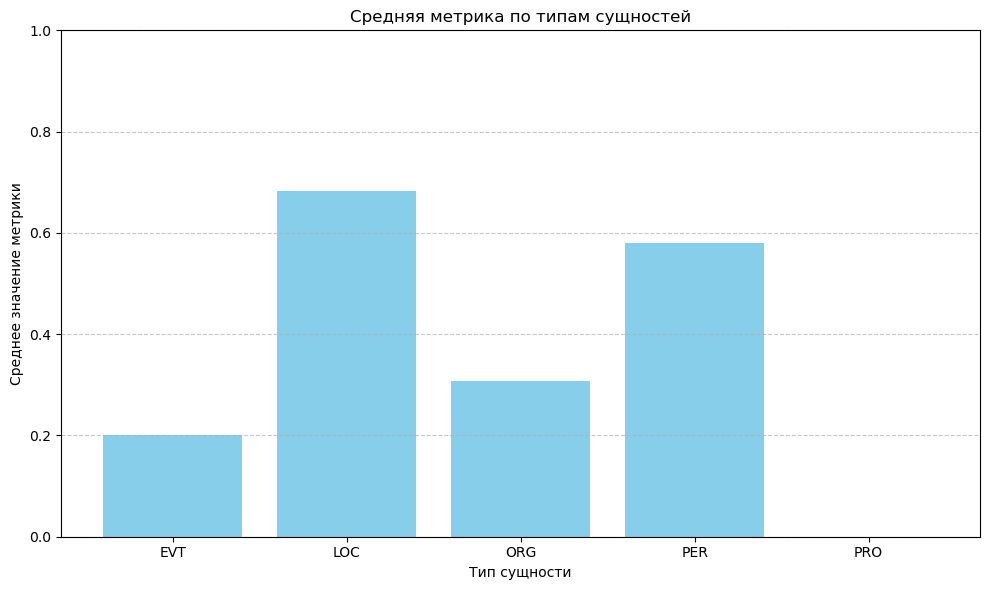

In [46]:
plt.figure(figsize=(10, 6))
plt.bar(entity_metrics['entity'], entity_metrics['metric'], color='skyblue')
plt.title('Средняя метрика по типам сущностей')
plt.xlabel('Тип сущности')
plt.ylabel('Среднее значение метрики')
plt.ylim(0, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

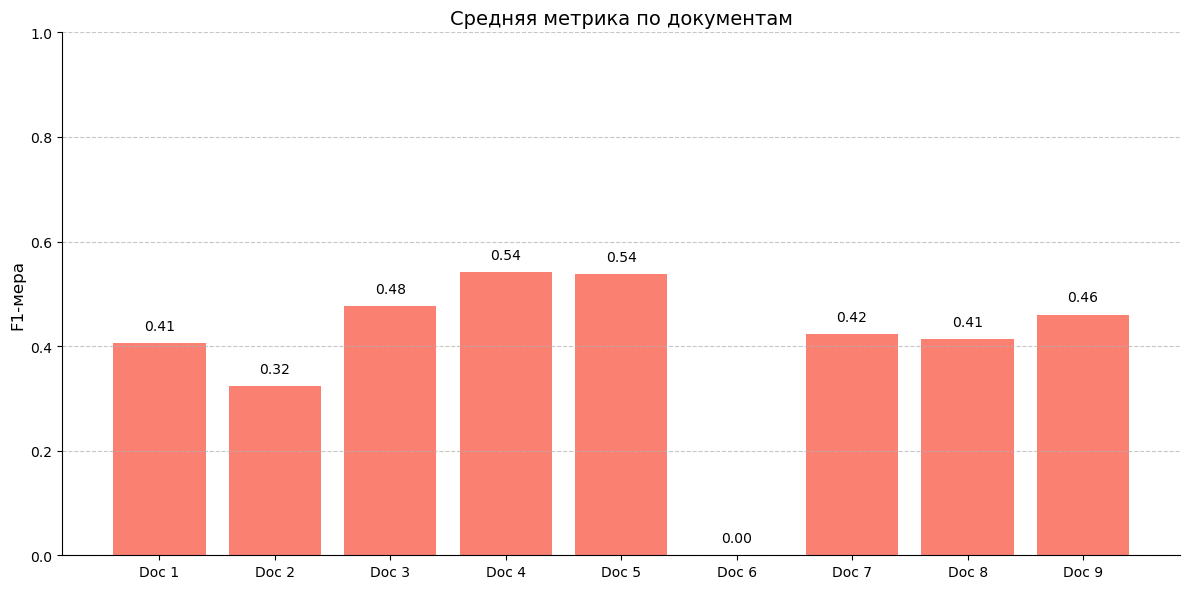


Соответствие номеров документов и их ID:
Документ 1: brexit_ru.txt_file_10
Документ 2: brexit_ru.txt_file_1000
Документ 3: brexit_ru.txt_file_1001
Документ 4: brexit_ru.txt_file_1002
Документ 5: brexit_ru.txt_file_1003
Документ 6: brexit_ru.txt_file_1004
Документ 7: brexit_ru.txt_file_1006
Документ 8: brexit_ru.txt_file_1011
Документ 9: brexit_ru.txt_file_1017


In [48]:
plt.figure(figsize=(12, 6))

doc_ids = document_metrics['document_id'].unique()
doc_labels = [f'Doc {i+1}' for i in range(len(doc_ids))]

plt.bar(range(len(document_metrics)), document_metrics['metric'], color='salmon')
plt.title('Средняя метрика по документам', fontsize=14)
plt.ylabel('F1-мера', fontsize=12)
plt.ylim(0, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(range(len(document_metrics)), doc_labels, rotation=0)

for i, value in enumerate(document_metrics['metric']):
    plt.text(i, value + 0.02, f'{value:.2f}', 
             ha='center', va='bottom', fontsize=10)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

print("\nСоответствие номеров документов и их ID:")
for i, doc_id in enumerate(doc_ids):
    print(f"Документ {i+1}: {doc_id}")

На основе полученных данных видно, что:

1) Для сущности PRO модель ни разу не ответила правильно, что связано с недостатком промта: возможно, нужно было привести пример такой сущности и указать как именно ее писать
2) Почти по всем файлам в среднем выдает одинаковые значения на метриках кроме файла 1004

## Задание 7
Есть ли зависимость метрик от длины документа? Постройте графики, чтобы ответить на вопрос.

In [50]:
df_grouped['doc_length_chars'] = df_grouped['document_text'].apply(len)
df_grouped['doc_length_words'] = df_grouped['document_text'].apply(lambda x: len(x.split()))

In [52]:
document_analysis = df_grouped.groupby('document_id').agg({
    'metric': 'mean',
    'doc_length_chars': 'first',
    'doc_length_words': 'first'
}).reset_index()

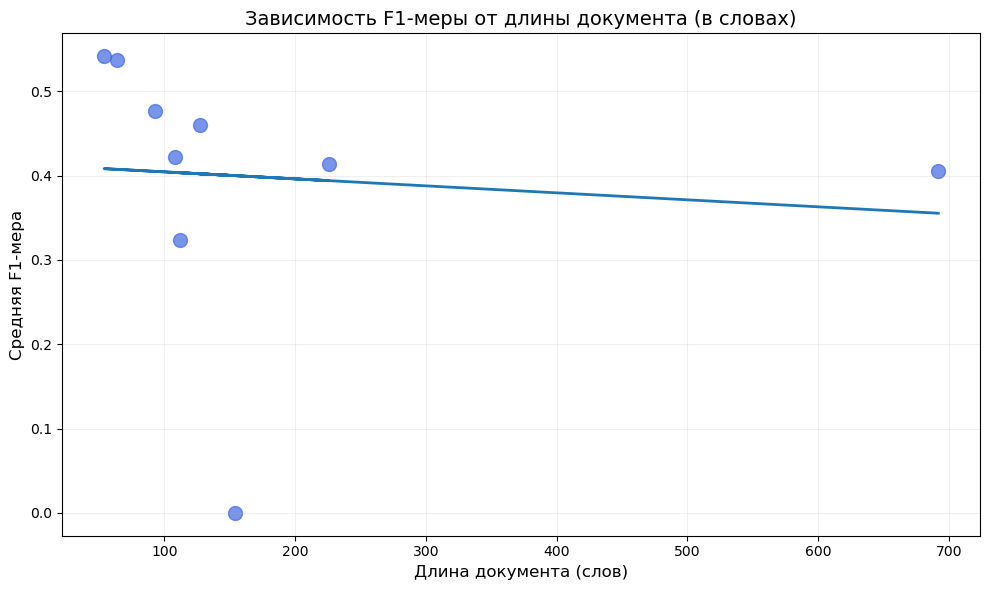

In [54]:
plt.figure(figsize=(10, 6))
plt.scatter(
    document_analysis['doc_length_words'], 
    document_analysis['metric'],
    s=100,
    alpha=0.7,
    color='royalblue'
)

z = np.polyfit(document_analysis['doc_length_words'], document_analysis['metric'], 1)
p = np.poly1d(z)
plt.plot(
    document_analysis['doc_length_words'], 
    p(document_analysis['doc_length_words']), 
    linewidth=2
)

plt.title('Зависимость F1-меры от длины документа (в словах)', fontsize=14)
plt.xlabel('Длина документа (слов)', fontsize=12)
plt.ylabel('Средняя F1-мера', fontsize=12)
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

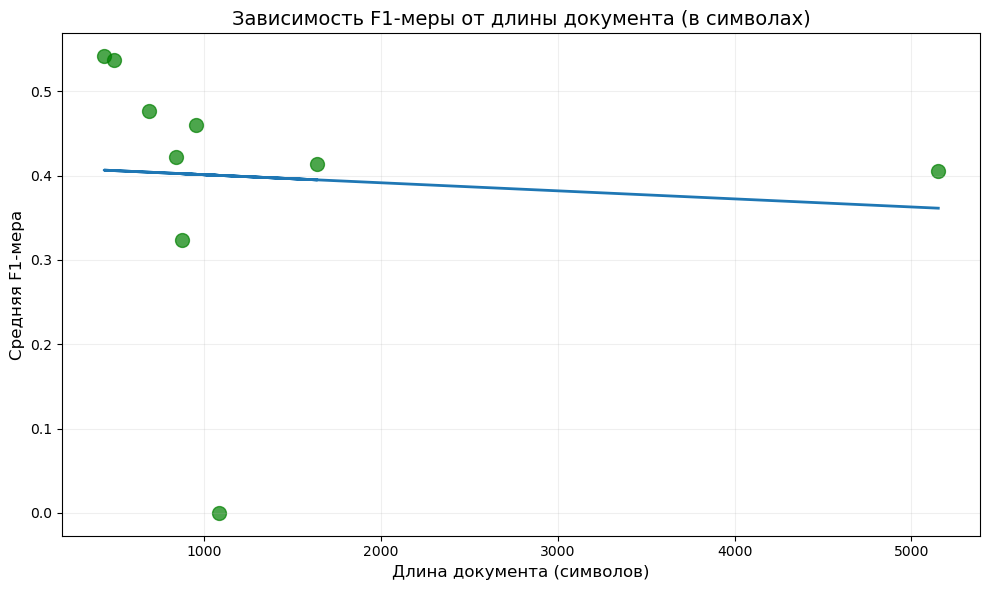

In [56]:
plt.figure(figsize=(10, 6))
plt.scatter(
    document_analysis['doc_length_chars'], 
    document_analysis['metric'],
    s=100,
    alpha=0.7,
    color='green'
)

z = np.polyfit(document_analysis['doc_length_chars'], document_analysis['metric'], 1)
p = np.poly1d(z)
plt.plot(
    document_analysis['doc_length_chars'], 
    p(document_analysis['doc_length_chars']), 
    linewidth=2
)

plt.title('Зависимость F1-меры от длины документа (в символах)', fontsize=14)
plt.xlabel('Длина документа (символов)', fontsize=12)
plt.ylabel('Средняя F1-мера', fontsize=12)
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

In [58]:
corr_words = document_analysis['doc_length_words'].corr(document_analysis['metric'])
corr_chars = document_analysis['doc_length_chars'].corr(document_analysis['metric'])

print(f"Корреляция с длиной в словах: {corr_words:.3f}")
print(f"Корреляция с длиной в символах: {corr_chars:.3f}")

Корреляция с длиной в словах: -0.100
Корреляция с длиной в символах: -0.086


Как мы видим по корреляции и по графикам, связь между длиной документа и метрикой почти отсутствует. Однако это зависит еще и от промта: при другой вариации промта я получал плохую линейную зависимость, но в такой вариации как сейчас зависимость отсутствует

## Задание 8
Проведите анализ ошибок. Когда модель чаще отвечает правильно, а когда ошибается? Предложите варианты, как повысить метрики.

С учетом графиков можно провести анализ ошибок и выявить плюсы и минусы: 

Плюсы:

1) Модель хорошо отвечает, когда сущности четко выражены и многократно упоминаются в тексте
2) Контекст в тексте выделен и легко понятен
3) Хорошо обработанный список в gold_answers

Минусы:

1) Плохо сделанный список верных ответов: основная проблематика заключается в том. что есть список [Brexit, брекзит, брексит] и для ответа модели в виде брекзит по хорошему нужно бы получать метрику 1, так как модель все верно определила, однако F1 мера будет 0.5. Тут появляется желание сделать метрику по попаданиям в список, однако так мы уходим от другой, более важной проблемы: если в списке содержится несколько сущностей, относящихся к одному классу, то начнем сильно завышать метрику. Оптимальный результат тут - ручная обработка финального датасета, оставляя только те слова, которые пересекаются с ответом модели в нужных формах. Также еще одно решение: брать эмбеддинги и смотреть на их близость к ответам модели (например косинусная близость) и на основе этого выдавать уже сами значения метрики.
2) Модель может не вставлять сокращения, если они не использовались в тексте
3) Плохо распознает слова, которые были использованы один раз или в целом мало относительно текста

Повышение метрики:

1) Улучшение промта и его автоматизация для запросов (чтобы не копировать ответы и просто сразу смотреть на результаты)
2) Векторные представления слов, как описано в первом пункте минусов
3) В целом улучшение gold_answers и аккуратная работа с разным вариантом написания одних и тех же слов 

## Задание 9
Сделайте выводы по всему исследованию. Напишите, чему научились и что нового попробовали.

В ходе работы я провел полный цикл обработки и анализа данных по распознаванию сущностей в различных текстах новостей. Основные выводы - в предыдущем задании. Основные сложности были при обработке текстовых файлов и сырых данных, а также при подборе корректного промта для данной задачи. В целом, в таком виде с задачей NER я до этого не встречался, поэтому было очень интересно попробовать. 